In [1]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\best SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\best SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\best SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


## First define the functions we will need to use
### The Structural Image Autocorrelation (SIA) function is the second function defined below

In [2]:
### this function (newRadav) finds the radial average of the image autocorrelation in the SIA function 
def newRadav(im, limangles=False, angRange=None, mask=None, rev=False,
             debug_q = None):
    if mask is None:
        hasMask = False
    else:
        hasMask = True
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    #x,y = np.meshgrid(xx,yy)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    angles = np.arctan2(x,y)
    
    qx = np.arange(-1*nx/2,nx/2)*(1./nx) * max(nx,ny)
    qy = np.arange(-1*ny/2,ny/2)*(1./ny) * max(nx,ny)
    qxx,qyy = np.meshgrid(qy,qx) #qy,qx is correct order
    q_new = np.sqrt(qxx**2 + qyy**2)
    
    if debug_q is not None:
        return q_new.round().astype(int)==debug_q
    
    if mask is None:
        mask = np.ones_like(angles)
    if angRange is not None:
        w1 = np.where(angles>angRange[0])
    else:
        w1 = np.where(angles>(13*np.pi/14))
    if mask is None:
        mask[w1]=0
        mask = mask * np.rot90(np.rot90(mask))
        mask = mask * np.flipud(mask)
        mask[np.where(mask==0)] = np.nan
        if rev:
            mask = np.rot90(mask)
    qr = q_new.round().astype(int)
    #rs = np.arange(0,(nx-1)/2)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            if limangles or hasMask:
                newim = im*mask
                radav[i] = np.nanmean(newim[w])
            else:
                radav[i] = np.nanmean(im[w])
        #else:
        #    print i
    return radav

### the SIA function 
def SIA(image, filter=True, filtersize=600, bin=True, binsize=2):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    
    ### Crop image
    #image = im[:1440, :1440]    ###option to crop out any large noise features 
        
    if filter:
        image = image*1.0 - uf(image,filtersize)   ###uniform filter, removes background. ("filtersize" is pixel area)
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)   ### OPTIONAL (binning makes things run faster)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    ### radial average taken
    rav_corr = newRadav(corr_im)
    
    ### return ONLY rav_corr **b/c I don't need corr_im** (change this if you do need corr_im) 
    return rav_corr

###not sure if this function is necessary
def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

###define the single exponential we use to fit SIA curves
def single_exponential(x, As, ls):
    return (As*np.exp(-x/ls)) 

### define function to systematically reduce the fit length until the fit parameters meet the specific criteria
###### this function was much more relevant for finicky double exponential fits, it doesn't do much for single exponential fits
def check_fits(A, l1, y_array, retry_num):
    if A == br_A:
        row = "(br) "
    elif A == mr_A:
        row = "(mr) "
    else:
        row = "(tr) "
    j=1
    skip_to_next = 0
    if (A < 0.049) or (l1 > 180.0): ##this line sets the specific criteria for fit params to meet
        try_again = True
        print("     poor fit at "+row+ time)
        while try_again:
            new_fit_lim = fit_lim - ((2*j))
            x_fit_lim = all_xvalues[new_fit_lim]
            try:
                popt, pcov = curve_fit(single_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], p0 = [0.5,7.0])
            except RuntimeError:
                print("RuntimeError - curve_fit failed")
                skip_to_next = 1
            print("        "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, l1=%5.3f' % tuple(popt))
            A, l1 = tuple(popt)
            x_fit_values = np.linspace(all_xvalues[1], all_xvalues[new_fit_lim], 1000)
            if (j == (retry_num-1)) or ((np.abs(l1)) < 0.1):
                print("   poor fit at "+row+ time + " --> try double exponential fit?")
                try_again = False
                try_single = True
                i = 0

            elif (A < 0.049) or (skip_to_next == 1):
                try_again = True
                skip_to_next = 0
                j = j+1
            else:
                try_again = False
                print("  yay!! good fit at "+row+time)
                print("  "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, l1=%5.3f' % tuple(popt))
    return [A, l1]

## Locate your data (tiff files) and choose where to save results     

In [3]:
directory = "Z"
exp = "7-18-22_bkaiB_ratios"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
### "plot_saveto" is the pathway to the folder where plots and results will be saved
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 36 files
 0 	 bottom_row_t01_MMStack_Pos0.ome.tif
 1 	 bottom_row_t02_MMStack_Pos0.ome.tif
 2 	 bottom_row_t03_MMStack_Pos0.ome.tif
 3 	 bottom_row_t04_MMStack_Pos0.ome.tif
 4 	 bottom_row_t05_MMStack_Pos0.ome.tif
 5 	 bottom_row_t06_MMStack_Pos0.ome.tif
 6 	 bottom_row_t07_MMStack_Pos0.ome.tif
 7 	 bottom_row_t08_MMStack_Pos0.ome.tif
 8 	 bottom_row_t09_MMStack_Pos0.ome.tif
 9 	 bottom_row_t10_MMStack_Pos0.ome.tif
 10 	 bottom_row_t11_MMStack_Pos0.ome.tif
 11 	 bottom_row_t12_MMStack_Pos0.ome.tif
 12 	 middle_row_t01_MMStack_Pos0.ome.tif
 13 	 middle_row_t02_MMStack_Pos0.ome.tif
 14 	 middle_row_t03_MMStack_Pos0.ome.tif
 15 	 middle_row_t04_MMStack_Pos0.ome.tif
 16 	 middle_row_t05_MMStack_Pos0.ome.tif
 17 	 middle_row_t06_MMStack_Pos0.ome.tif
 18 	 middle_row_t07_MMStack_Pos0.ome.tif
 19 	 middle_row_t08_MMStack_Pos0.ome.tif
 20 	 middle_row_t09_MMStack_Pos0.ome.tif
 21 	 middle_row_t10_MMStack_Pos0.ome.tif
 22 	 middle_row_t11_MMStack_Pos0.ome.tif
 23 	 middle_row_t12_MMStack_

## Specify pixel size, each condition (frame_names), and the time points of data collection (time_array)

In [4]:
frame_names = ["50% bKaiB", "35% bKaiB", "20% bKaiB", "AE (20% bKaiB)"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.364 # 4*0.091 = 0.364
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/3)
print("total number of time points: "+ str(arr_length))

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\best SIA\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


tiff file dimensions: (4, 1440, 1920)
total number of time points: 12


## Choose size, font, and quality level (dpi_num) for the plots to be made

In [5]:
fig_size = 10,10/1.618
###  size of output figures
font_size = 16
### font size
dpi_num = 800
### image quality level (recommendation: 600)

In [ ]:
frame_key = 3
condition = frame_names[frame_key]
print(condition)

fig = plt.figure(figsize=(10,10))    #figsize=(10,10)
for i in range (arr_length):
    ax = plt.subplot(3,3,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    test_image = tiff_file.imread(files[i],key=[frame_key])
    
    filtered_image = filtimage(test_image, filtersize=600)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    ax.matshow(fully_processed_image, cmap = 'gray')
    #ax.matshow(test_image, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout(pad=.2)
fig.savefig(data_dir2+"SIA proccessed images for row1 "+condition+".jpg", dpi=dpi_num)

In [ ]:
frame_key = 3
condition = frame_names[frame_key]
print(condition)

fig = plt.figure(figsize=(10,10))    #figsize=(10,10)
for i in range (arr_length):
    ax = plt.subplot(3,3,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    test_image = tiff_file.imread(files[i],key=[frame_key])
    
    filtered_image = filtimage(test_image, filtersize=600)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    #ax.matshow(fully_processed_image, cmap = 'gray')
    ax.matshow(test_image, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout(pad=.2)
fig.savefig(data_dir2+"SIA raw images for "+condition+".jpg", dpi=dpi_num)

## Set up empty arrays to save results in 

In [6]:
im_array = [0.0] * int(arr_length)
br_corr_rad_array = [0.0] * int(arr_length)
mr_corr_rad_array = [0.0] * int(arr_length)
tr_corr_rad_array = [0.0] * int(arr_length)

br_plat_vals = [0.0] * int(arr_length)
mr_plat_vals = [0.0] * int(arr_length)
tr_plat_vals = [0.0] * int(arr_length)

all_xvalues = [0.0] * int(len(files))

## Now we can run some SIA! 

<IPython.core.display.Javascript object>


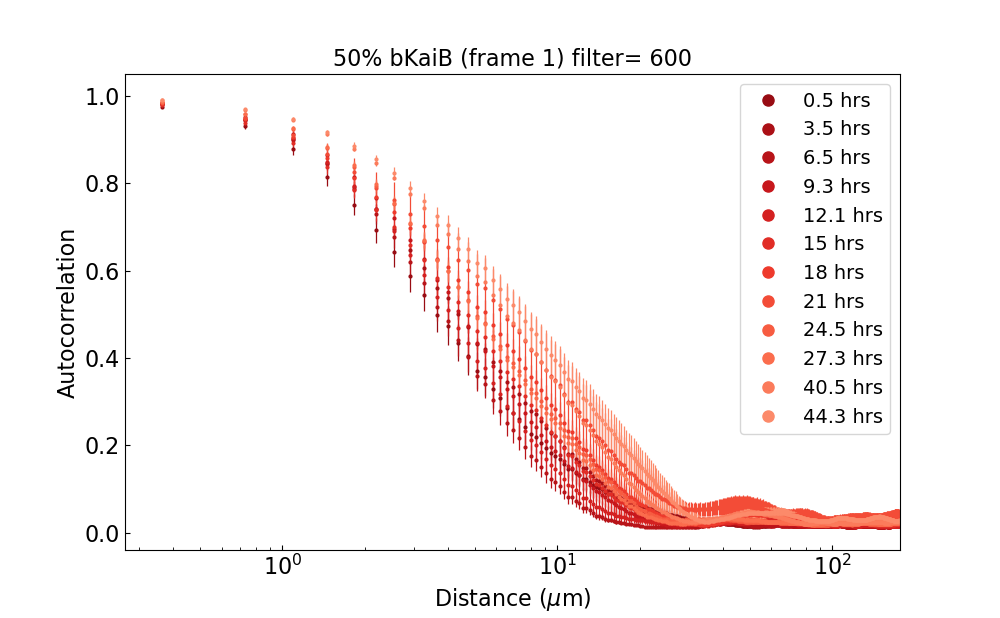

long length plateau range: from 30.940 to 100.100
image size: 174.356 x 174.356 um, last x-value= 174.356


<ipython-input-7-a96668fc5e9f>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [7]:
key = 0
### "key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed, tiff_file.imread(files[i],key=[key]

cmap = matplotlib.cm.get_cmap('Reds') 
### cmap dictates the color gradient used in plots; options: 'Reds' 'Blues' 'Greens' 'Greys' ... 

t_f = True
### If true, filters images to remove excess fluorescense background or other noise

size = 600  
### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600

plat_range_from = 85
plat_range_to = 275
### set the range for finding average autocorrelation values of long distance correlation plateaus

### Set basic plot design 
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
### cmap_num is used the when plotting each curve to adjust the color gradient according to the total number of time points
### e.g. for i in range(arr_length): the color of each curve is determined by c=cmap(0.9-(i/cmap_num))

### Set up more empty arrays to save results in
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))
all_plat_vals = np.zeros((3,1))
avg_plats  = np.empty(arr_length)
std_error_plats = np.empty(arr_length)

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1)    ### used in plot title to specify which frame of all tiff files was analyzed
    data_file = str(time_array[i]) + " hrs" ### used in legend to show time points corresponding to each curve
    
### "im_corr" is the actual SIA function which filters, bins, and fourier transforms tiff images to generate SIA curves
    br_corr_rad_array[i] = SIA(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = SIA(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = SIA(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
### corresponding x-values calculated according to the length of a SIA curve array (br_corr_rad_array[0]) and pixel size
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
### this block calculates the average and std error of the 3 SIA curves ("br_corr_rad_array[i]", "mr_corr_rad_array[i]", and 
### "tr_corr_rad_array[i]") generated from the specified frame (key) of 3 tiff files corresponding to time point "time_array[i]"
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
### this block finds average autocorrelation values of long distance correlation plateaus for the 3 SIA curves 
    br_plat_vals[i] = np.mean(br_corr_rad_array[i][plat_range_from:plat_range_to])
    mr_plat_vals[i] = np.mean(mr_corr_rad_array[i][plat_range_from:plat_range_to])
    tr_plat_vals[i] = np.mean(tr_corr_rad_array[i][plat_range_from:plat_range_to])
    
### this block calculates the average and std error of the 3 long distance correlation plateau values found above^
    all_plat_vals[0] = br_plat_vals[i]
    all_plat_vals[1] = mr_plat_vals[i]
    all_plat_vals[2] = tr_plat_vals[i]
    avg_plats[i] = all_plat_vals.mean(axis=0)
    std_error_plats[i] = (all_plat_vals.std(axis=0))/np.sqrt(3)
    
### plot the average SIA curves for each time point with the std error as error bars 
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) 
    

print("long length plateau range: from %5.3f to %5.3f" %(all_xvalues[plat_range_from], all_xvalues[plat_range_to]))
print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))

### legend, labels and title for the plot 
### **note: the title determined in this code block carries over to all other plots unless otherwise specified 
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
ax.tick_params(direction='in', which='both', labelsize=font_size)

### x-axis limit is set slighlty larger than the image size, based on "all_xvalues[-1]" 
plt.xlim(0, all_xvalues[-1] +2) 

### set title
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [8]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)
print(plot_saveto)

Z:\Gregor L\__Kai Colloids\SIA\Data\7-18-22_bkaiB_ratios\


<IPython.core.display.Javascript object>


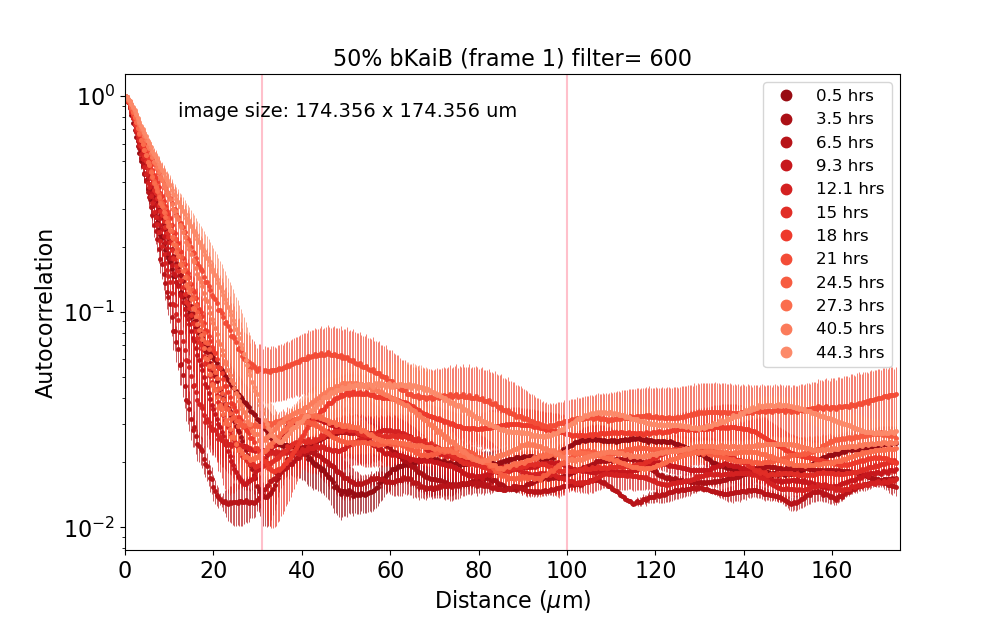

In [9]:
### re-plot average SIA curves on log-y linear-x  

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-4)
plt.axvline(x=all_xvalues[plat_range_from], color='pink', linestyle='-')
plt.axvline(x=all_xvalues[plat_range_to], color='pink', linestyle='-')
#plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(12,0.8, "image size: %5.3f x %5.3f um" %(all_xvalues[-1], all_xvalues[-1]), fontsize=font_size-2)
plt.title(title, fontsize=font_size)

### save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


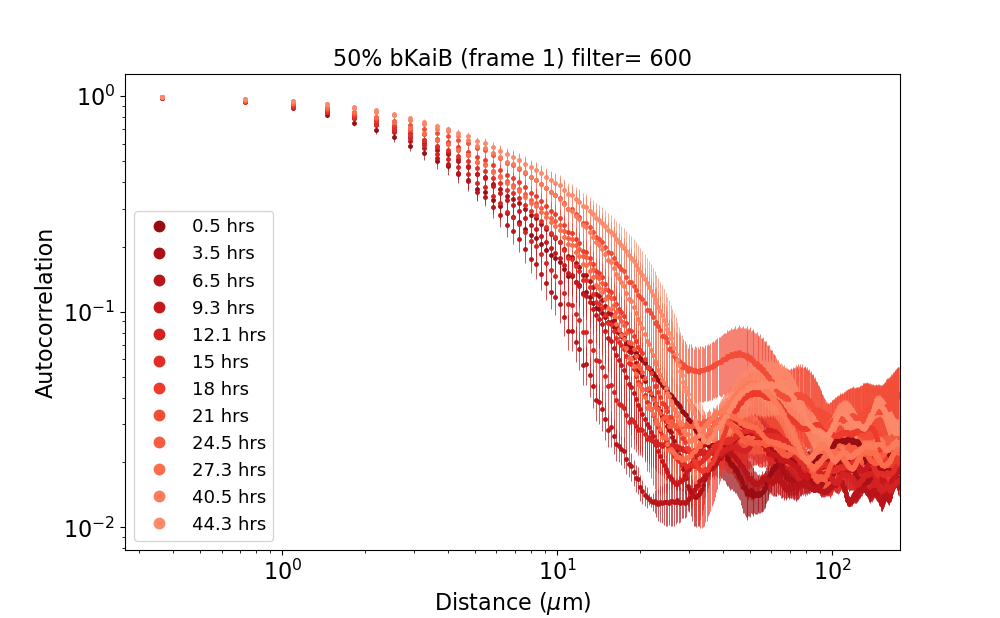

<ipython-input-10-fca4b4064533>:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [10]:
### re-plot average SIA curves on log-y log-x 

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
#plt.ylim(0.001, 0.05)
plt.xlim(0, all_xvalues[-1] +2)
#plt.xlim(30, 100)
plt.title(title, fontsize=font_size)

###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

## Now we fit the SIA curves to a single exponential, fit equation: y = A(e^(-x/L1))

<IPython.core.display.Javascript object>


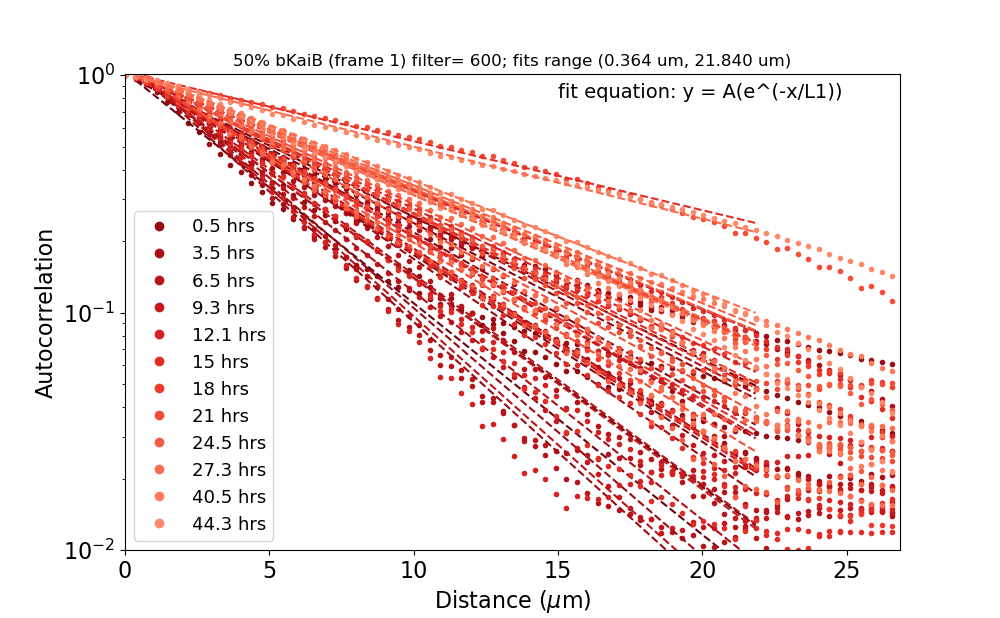

first x-value= 0.364, start fits from 0.364; fit until xlim = 21.840
Fits:
0.5 hrs-- br fit: A=1.068, l1=4.925
0.5 hrs-- mr fit: A=1.009, l1=7.231
0.5 hrs-- tr fit: A=1.033, l1=4.455
3.5 hrs-- br fit: A=1.051, l1=6.349
3.5 hrs-- mr fit: A=1.004, l1=6.952
3.5 hrs-- tr fit: A=1.072, l1=5.515
6.5 hrs-- br fit: A=1.144, l1=3.956
6.5 hrs-- mr fit: A=1.159, l1=4.156
6.5 hrs-- tr fit: A=1.145, l1=5.213
9.3 hrs-- br fit: A=1.124, l1=5.559
9.3 hrs-- mr fit: A=1.116, l1=4.523
9.3 hrs-- tr fit: A=1.076, l1=6.906
12.1 hrs-- br fit: A=1.169, l1=4.009
12.1 hrs-- mr fit: A=1.117, l1=4.893
12.1 hrs-- tr fit: A=1.087, l1=6.057
15 hrs-- br fit: A=1.085, l1=4.877
15 hrs-- mr fit: A=1.079, l1=5.566
15 hrs-- tr fit: A=1.028, l1=8.714
18 hrs-- br fit: A=1.061, l1=6.145
18 hrs-- mr fit: A=1.044, l1=7.476
18 hrs-- tr fit: A=1.030, l1=8.680
21 hrs-- br fit: A=1.037, l1=6.276
21 hrs-- mr fit: A=1.055, l1=7.196
21 hrs-- tr fit: A=1.029, l1=14.933
24.5 hrs-- br fit: A=1.098, l1=5.566
24.5 hrs-- mr fit: A=1.079, l

Text(0.5, 1.0, '50% bKaiB (frame 1) filter= 600; fits range (0.364 um, 21.840 um)')

In [11]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

### Set up dictionary ("results_dict") and more empty arrays to save results in
results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

### FIT PARAMETERS: adjust these to change the range for fitting attempts 
fit_start = 1
fit_lim = 60 
retry_num = 10 #retry_num is the number of fitting attempts to try before moving on, not very relevant to single exp fits
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[fit_start], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]

### load and plot the 3 original SIA curves corresponding to 3 tiff files associated with each time point 
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
### x_fit_values has the same range as "all_xvalues", but includes more values to produce better fits
    x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000) 

### the "curve_fit" function from scipy does the initial fitting attempt
    br_popt, br_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], br_y_array[fit_start:fit_lim]) #, p0 = [0.5,5.0]
    mr_popt, mr_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], mr_y_array[fit_start:fit_lim])
    tr_popt, tr_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], tr_y_array[fit_start:fit_lim])
    print(time+"-- "+'br fit: A=%5.3f, l1=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, l1=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, l1=%5.3f' % tuple(tr_popt))
    br_A, br_l1 = tuple(br_popt)
    mr_A, mr_l1 = tuple(mr_popt)
    tr_A, tr_l1 = tuple(tr_popt)
    
### the "check fits" function re-runs "curve_fit" with a slightly smaller range until the fit parameters meet our criteria
### specified in the "check fits" function, our fit parameters criteria was more relevant for double exponential fits
### (most single exponential fits work first try)
    br_A, br_l1 = check_fits(br_A, br_l1, br_y_array, retry_num)
    mr_A, mr_l1 = check_fits(mr_A, mr_l1, mr_y_array, retry_num)
    tr_A, tr_l1 = check_fits(tr_A, tr_l1, tr_y_array, retry_num)
    
### generate and plot curves based on the fits 
    br_fit_values = single_exponential(x_fit_values, *br_popt)
    mr_fit_values = single_exponential(x_fit_values, *mr_popt)
    tr_fit_values = single_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
### saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_l1]
    results_dict[time]["mr fit params"] = [mr_A, mr_l1]
    results_dict[time]["tr fit params"] = [tr_A, tr_l1]
    
    br_shortlengths[i] = (br_A, br_l1)
    mr_shortlengths[i] = (mr_A, mr_l1) 
    tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-3)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(15,0.8, "fit equation: y = A(e^(-x/L1))", fontsize=font_size-2)

title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)

In [12]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title_plus+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
#file_to_write = open(plot_saveto+ "SIA results for "+title_plus+".p", "wb")
pickle.dump(results_dict, file_to_write)

## Determine and plot the results of fitting SIA curves

[0.7004348  0.34007435 0.31850097 0.56346413 0.48415434 0.96421205
 0.59794174 2.24150643 0.63747417 0.4120946  0.1385917  1.55197196]
[[ 4.92528331  6.34885473  3.95566079  5.5592476   4.00886143  4.87696843
   6.14454094  6.2757631   5.56555371  7.57542042  8.18231484  8.1009308 ]
 [ 7.23104986  6.95167204  4.15606978  4.52266122  4.89339264  5.56632528
   7.47619777  7.19618078  7.02445679  6.46411876  8.60622868  9.24474062]
 [ 4.45465167  5.51503605  5.21317072  6.90649885  6.05664147  8.71372449
   8.68032415 14.93312774  8.26724791  5.85085861  8.74715446 14.28844817]]


<IPython.core.display.Javascript object>


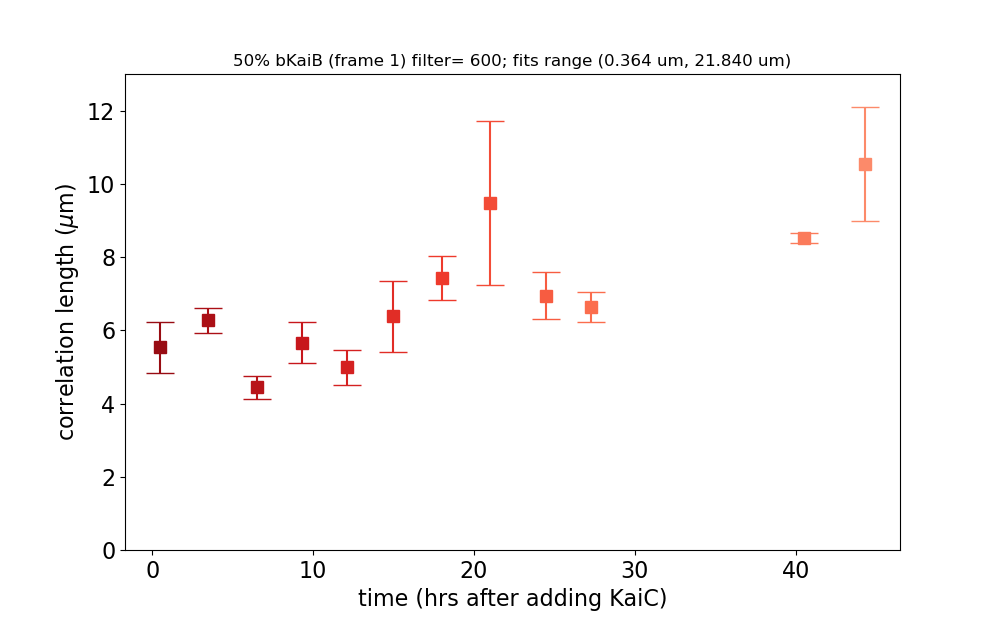

In [13]:
### set up empty arrays
all_L1 = np.zeros((3,len(br_shortlengths)))
avg_L1 = np.empty(len(br_shortlengths))
stderror_L1 = np.empty(len(br_shortlengths))

### find average values and std. error for L1 correlation lengths based on the fits 
for i in range(len(br_shortlengths)):
    all_L1[0,i] = br_shortlengths[i][1]
    all_L1[1,i] = mr_shortlengths[i][1]
    all_L1[2,i] = tr_shortlengths[i][1]
    #print(all_L1.mean(axis=0))
avg_L1 = all_L1.mean(axis=0)
stderror_L1 = all_L1.std(axis=0)/np.sqrt(3)
print(stderror_L1)
print(all_L1)

### plot average values and std. error for L1 correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_L1[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_L1[i], yerr = stderror_L1[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,13)
title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+"L1 correlation lengths for "+title_plus+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


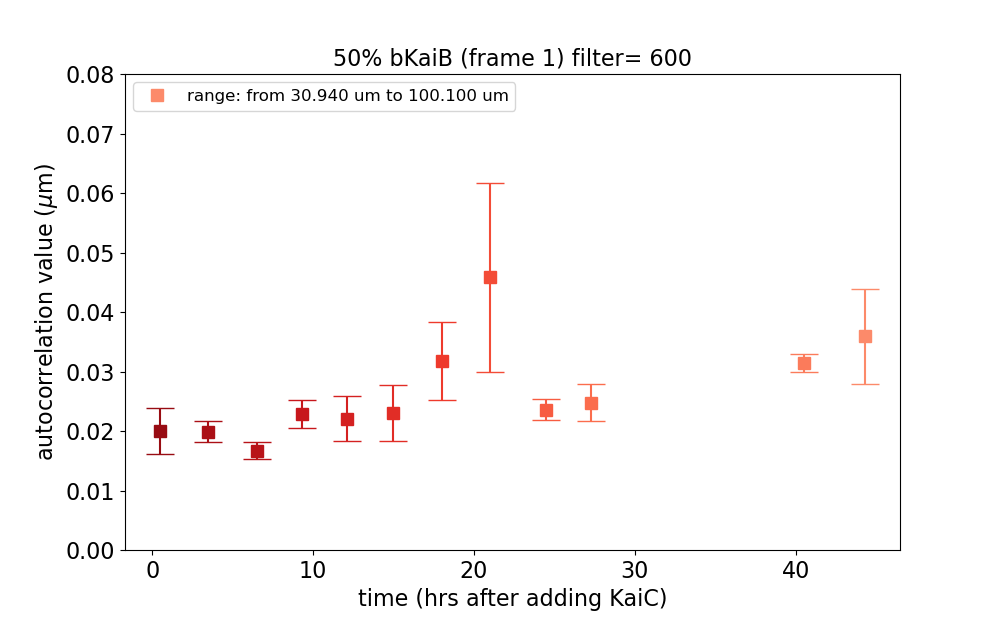

In [14]:
### plot average values and std. error for long range autocorrelation plateau values 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8
label_range = "range: from %5.3f um to %5.3f um" %(all_xvalues[plat_range_from], all_xvalues[plat_range_to])

for i in range(int(len(time_array))):
    plat_plot, = plt.plot(time_array[i], avg_plats[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = label_range)
    ax.errorbar(time_array[i], avg_plats[i], yerr = std_error_plats[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)


plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,0.08)

plt.title(title, fontsize=font_size)
ax.legend(handles =[plat_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

### save plot
fig.savefig(plot_saveto+"long range autocorrelation for "+title+".jpg", dpi=dpi_num)

In [15]:
### set p_range to the range of long range autocorrelation plateau values, use for saving data in CSV files
p_range = '(%5.1f, %5.1f)' %(all_xvalues[plat_range_from], all_xvalues[plat_range_to])
print(p_range)

( 30.9, 100.1)


## Save all results to 3 seperate CSV files --> use for plotting in origin later on 

In [16]:
### first CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br A','mr A','tr A','','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error','','br plateau','mr plateau','tr plateau', 
                     'avg plateau '+p_range, 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_shortlengths[i][0], mr_shortlengths[i][0], tr_shortlengths[i][0], _[i],
                         br_shortlengths[i][1], mr_shortlengths[i][1], tr_shortlengths[i][1],
                        avg_L1[i], stderror_L1[i], _[i], br_plat_vals[i], mr_plat_vals[i], tr_plat_vals[i], 
                         avg_plats[i], std_error_plats[i]])
    writer.writerow([''])
f.close()

### second CSV file: save raw data (x and y values) of each original SIA curve (3 curves for each time point)
csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

### third CSV file: save the raw data (x and y values) of each fit to each original SIA curve (3 curves for each time point)
csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

## First round complete! 
## Now we can scroll back to the top and change the 'key' variable to run through the next frame (i.e. condition) of all tiff files